<a href="https://colab.research.google.com/github/shreya2057/ace_project/blob/master/pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders

In [ ]:
splitfolders.ratio('/content/drive/MyDrive/ACE PROJECT', output='output', seed=1337, ratio=(.8,.1, .1), group_prefix=None)

Copying files: 5216 files [04:04, 21.29 files/s] 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import pickle
import cv2
import PIL
import pathlib
import tensorflow as tf

In [ ]:
import easydict
args = easydict.EasyDict({
        "test": "/content/output/test",
        "train":"/content/output/train",
        "val" :"/content/output/val",
})

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
BATCH_SIZE = 32
IMG_SIZE = (240, 240)

In [ ]:
train_dataset = image_dataset_from_directory(args['train'],
                                             shuffle=True,
                                             label_mode='categorical',
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(args['test'], image_size=IMG_SIZE,
                                            label_mode='categorical'
                                            )
val_dataset = image_dataset_from_directory(args['val'],
                                           label_mode = 'categorical',
                                           batch_size=BATCH_SIZE,
                                           image_size=IMG_SIZE)
class_names = test_dataset.class_names

Found 4172 files belonging to 2 classes.
Found 523 files belonging to 2 classes.
Found 521 files belonging to 2 classes.


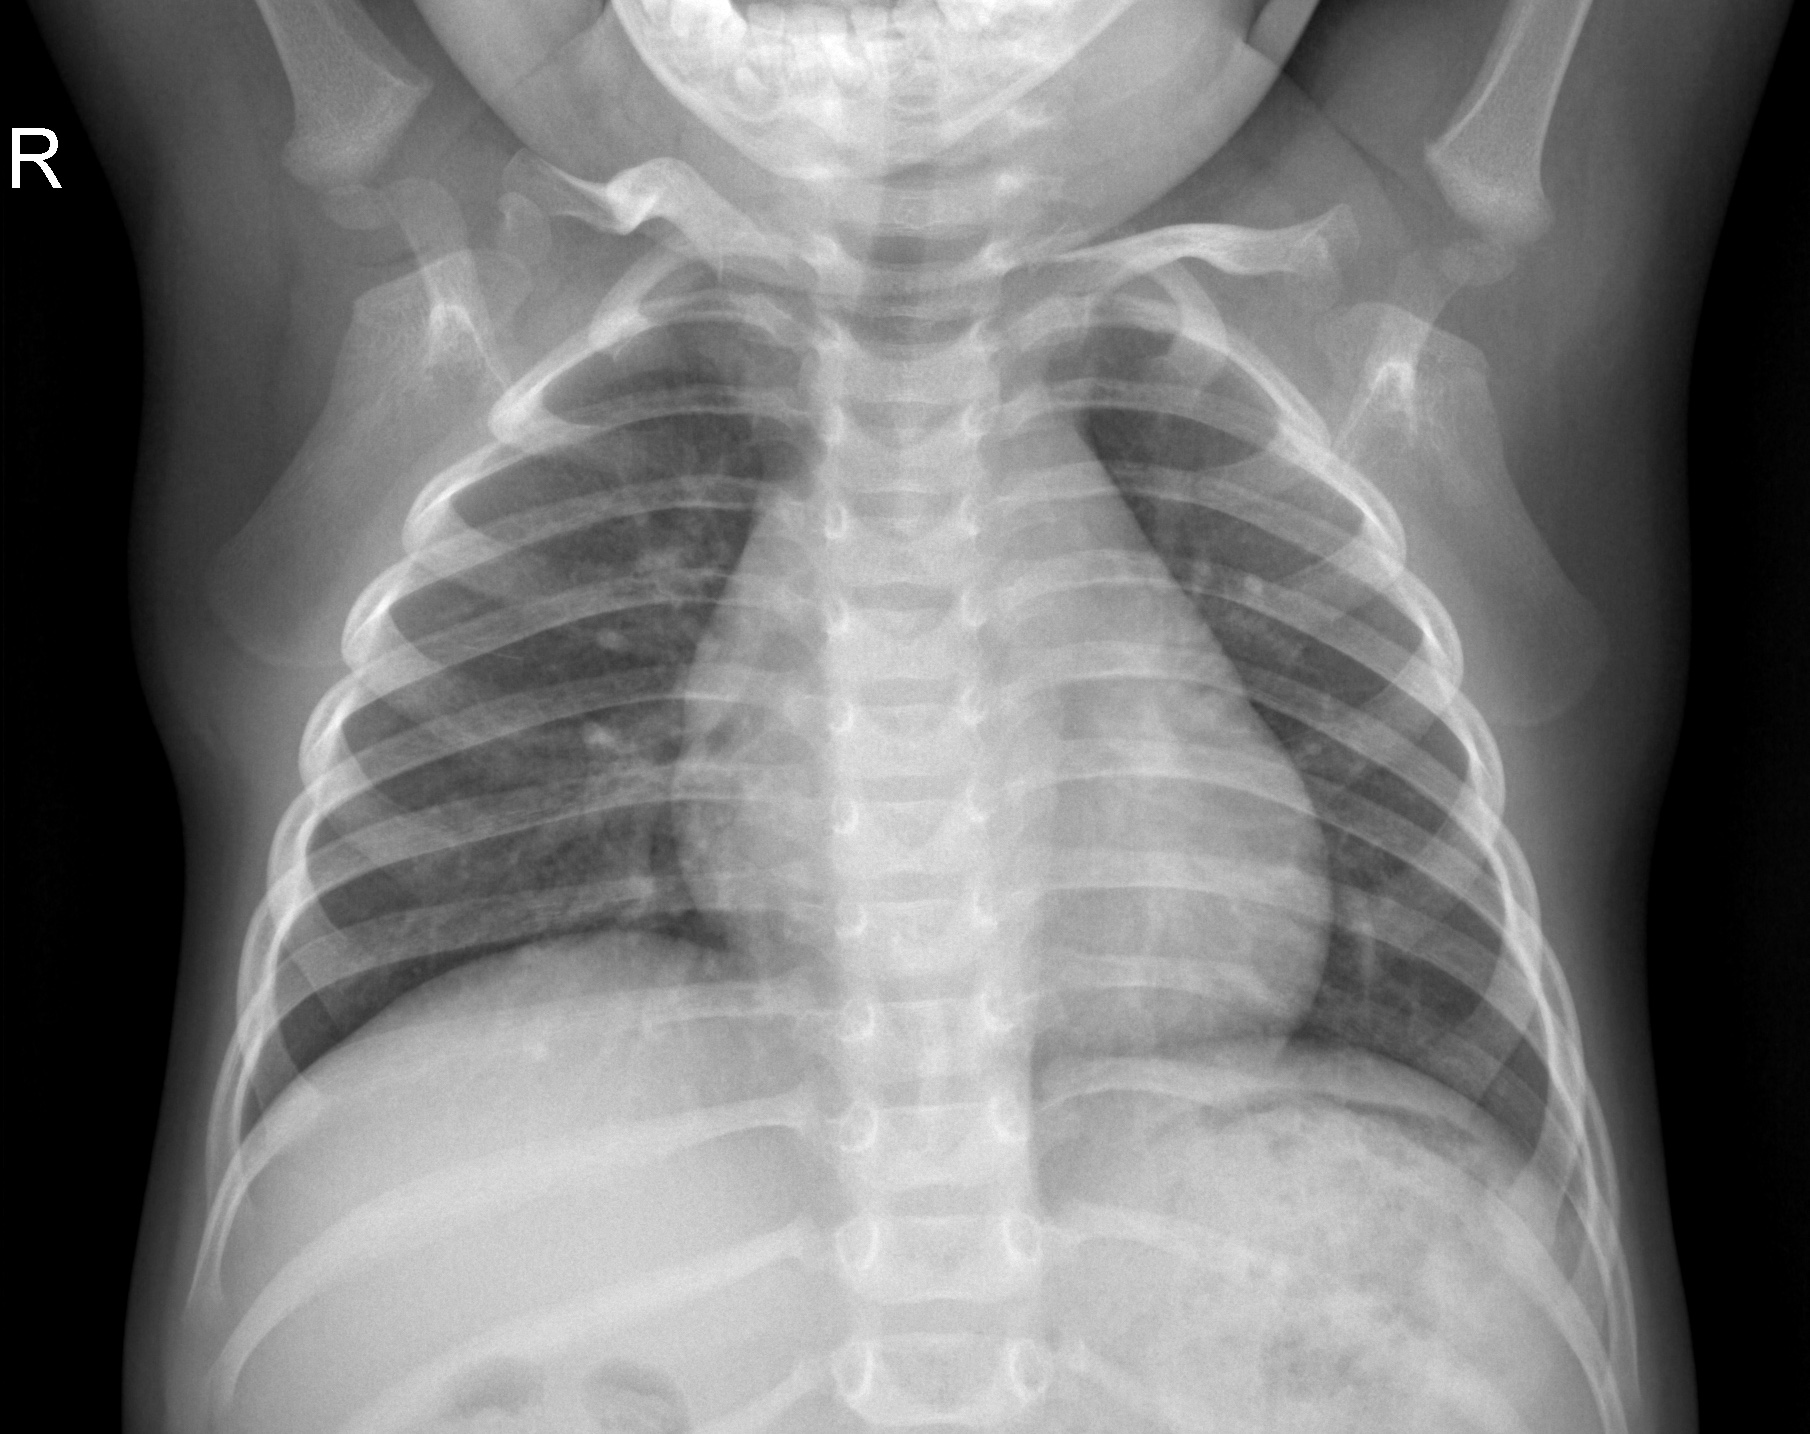

In [ ]:
img_1 = os.path.join('/content/drive/MyDrive/ACE PROJECT/Normal/IM-0119-0001.jpeg')
PIL.Image.open(str(img_1))

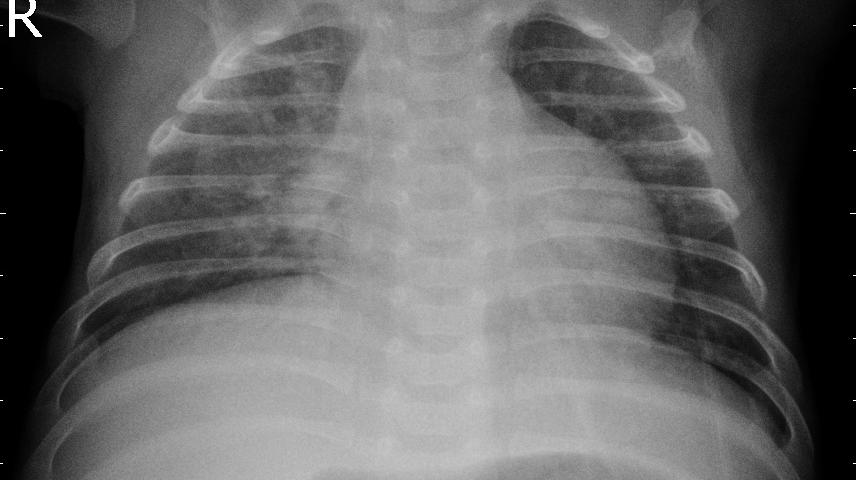

In [ ]:
img_2 = os.path.join('/content/drive/MyDrive/ACE PROJECT/Pneumonia/person1004_virus_1686.jpeg')

PIL.Image.open(str(img_2))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

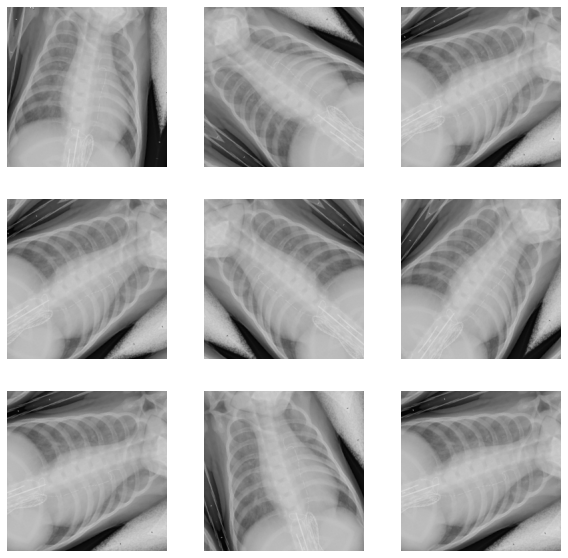

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 8, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 120, 120, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 120, 120, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(2, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [ ]:
inputs = tf.keras.Input(shape=(240, 240, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 240, 240, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 240, 240, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 240, 240, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=val_dataset)

Epoch 1/15
131/131 [==============================] - 216s 2s/step - loss: 0.4978 - accuracy: 0.7512 - val_loss: 0.4362 - val_accuracy: 0.7505
Epoch 2/15
131/131 [==============================] - 215s 2s/step - loss: 0.4003 - accuracy: 0.7960 - val_loss: 0.3726 - val_accuracy: 0.8023
Epoch 3/15
131/131 [==============================] - 217s 2s/step - loss: 0.3382 - accuracy: 0.8663 - val_loss: 0.3282 - val_accuracy: 0.8445
Epoch 4/15
131/131 [==============================] - 215s 2s/step - loss: 0.2956 - accuracy: 0.9048 - val_loss: 0.2976 - val_accuracy: 0.8599
Epoch 5/15
131/131 [==============================] - 215s 2s/step - loss: 0.2679 - accuracy: 0.9250 - val_loss: 0.2711 - val_accuracy: 0.8887
Epoch 6/15
131/131 [==============================] - 217s 2s/step - loss: 0.2453 - accuracy: 0.9353 - val_loss: 0.2523 - val_accuracy: 0.9021
Epoch 7/15
131/131 [==============================] - 216s 2s/step - loss: 0.2279 - accuracy: 0.9370 - val_loss: 0.2400 - val_accuracy: 0.9021

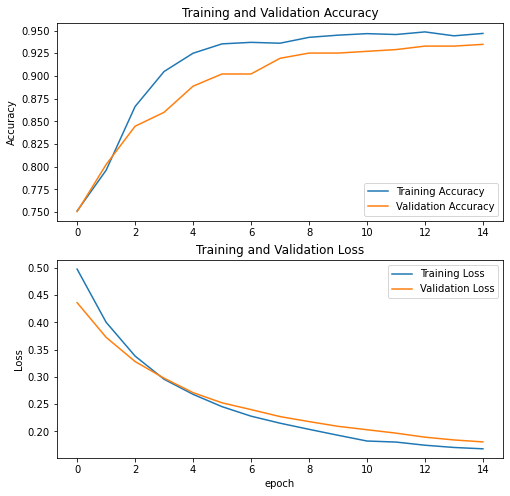

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend();

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.show();

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 5
total_epochs =  15 + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                          validation_data=val_dataset)

Epoch 1/20
131/131 [==============================] - 357s 3s/step - loss: 0.1427 - accuracy: 0.9425 - val_loss: 0.1219 - val_accuracy: 0.9520
Epoch 2/20
131/131 [==============================] - 350s 3s/step - loss: 0.1094 - accuracy: 0.9581 - val_loss: 0.0990 - val_accuracy: 0.9482
Epoch 3/20
131/131 [==============================] - 345s 3s/step - loss: 0.0957 - accuracy: 0.9626 - val_loss: 0.2264 - val_accuracy: 0.9328
Epoch 4/20
131/131 [==============================] - 346s 3s/step - loss: 0.0884 - accuracy: 0.9645 - val_loss: 0.0835 - val_accuracy: 0.9578
Epoch 5/20
131/131 [==============================] - 346s 3s/step - loss: 0.0736 - accuracy: 0.9734 - val_loss: 0.0873 - val_accuracy: 0.9674
Epoch 6/20
131/131 [==============================] - 348s 3s/step - loss: 0.0692 - accuracy: 0.9746 - val_loss: 0.1120 - val_accuracy: 0.9597
Epoch 7/20
131/131 [==============================] - 345s 3s/step - loss: 0.0653 - accuracy: 0.9741 - val_loss: 0.0587 - val_accuracy: 0.9827

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

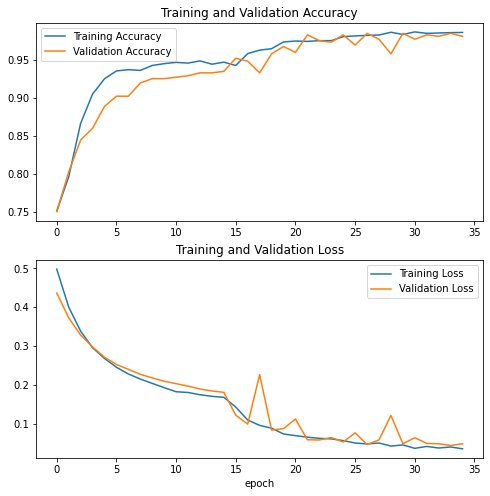

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.legend()
plt.show();

In [ ]:
model.evaluate(test_dataset)

17/17 [==============================] - 31s 2s/step - loss: 0.0373 - accuracy: 0.9885


[0.03734071925282478, 0.9885277152061462]

In [ ]:
model.save('saved_model/medical_pictures')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model1 = tf.keras.models.load_model('/content/saved_model/medical_pictures')
#model1.evaluate(test_dataset)

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model1.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.softmax(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

In [ ]:
from keras.models import load_model
from keras.preprocessing import image
import numpy as np

# dimensions of our images    -----   are these then grayscale (black and white)?
img_width, img_height = 240, 240

# load the model we saved

# Get test image ready
test_image = tf.keras.utils.load_img('/content/drive/MyDrive/ACE PROJECT/Normal/IM-0119-0001.jpeg', target_size=(img_width, img_height))
test_image = tf.keras.utils.img_to_array(test_image)
#print(type(test_image))
#print(test_image.shape)
test_image = np.expand_dims(test_image, axis=0)

test_image = test_image.reshape(240, 240, 3) 
test_image = np.expand_dims(test_image, axis=0)   # Ambiguity!
# Should this instead be: test_image.reshape(img_width, img_height, 3) ??

result = model1.predict(test_image, batch_size=1)
print ((result))

1/1 [==============================] - 0s 99ms/step
[[9.997479e-01 9.480907e-05]]


In [ ]:
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Labels:
 [[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


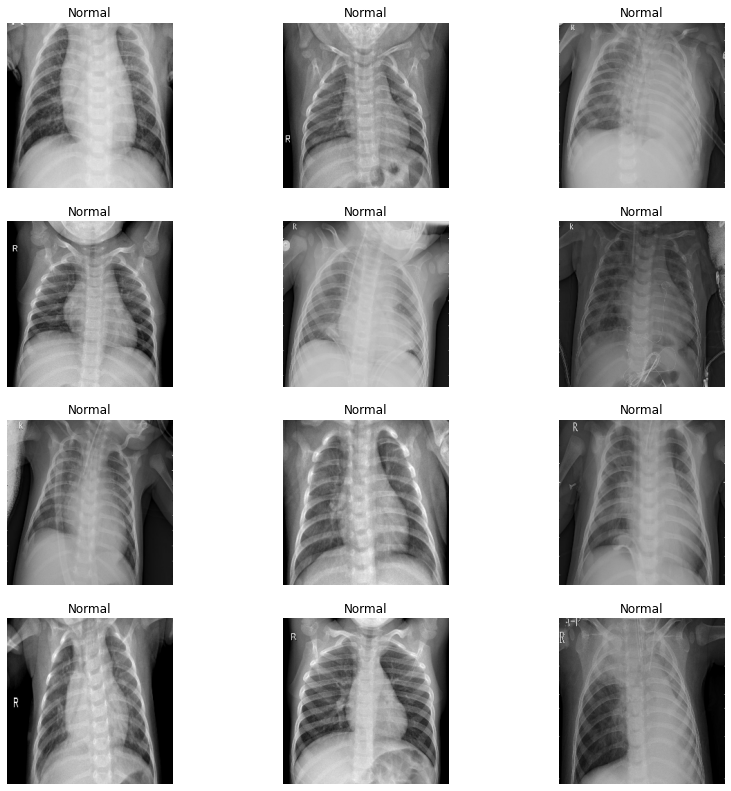

In [ ]:
plt.figure(figsize=(14, 14))
for i in range(12):
  ax = plt.subplot(4, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
from keras.preprocessing import image
import numpy as np

In [ ]:
def test_on_image(img_path):
  test_image = tf.keras.utils.load_img(img_path, target_size=(240,240))
  test_image = tf.keras.utils.img_to_array(test_image)
  #print(type(test_image))
  #print(test_image.shape)
  test_image = test_image.reshape(240, 240, 3)
  test_image = np.expand_dims(test_image, axis=0) 
  result = model1.predict(test_image)
  #print(type(result))
  p = max(result.tolist())
  return(class_names[p.index(max(p))])

In [ ]:
img_5 = "/content/drive/MyDrive/ACE PROJECT/Normal/IM-0129-0001.jpeg"

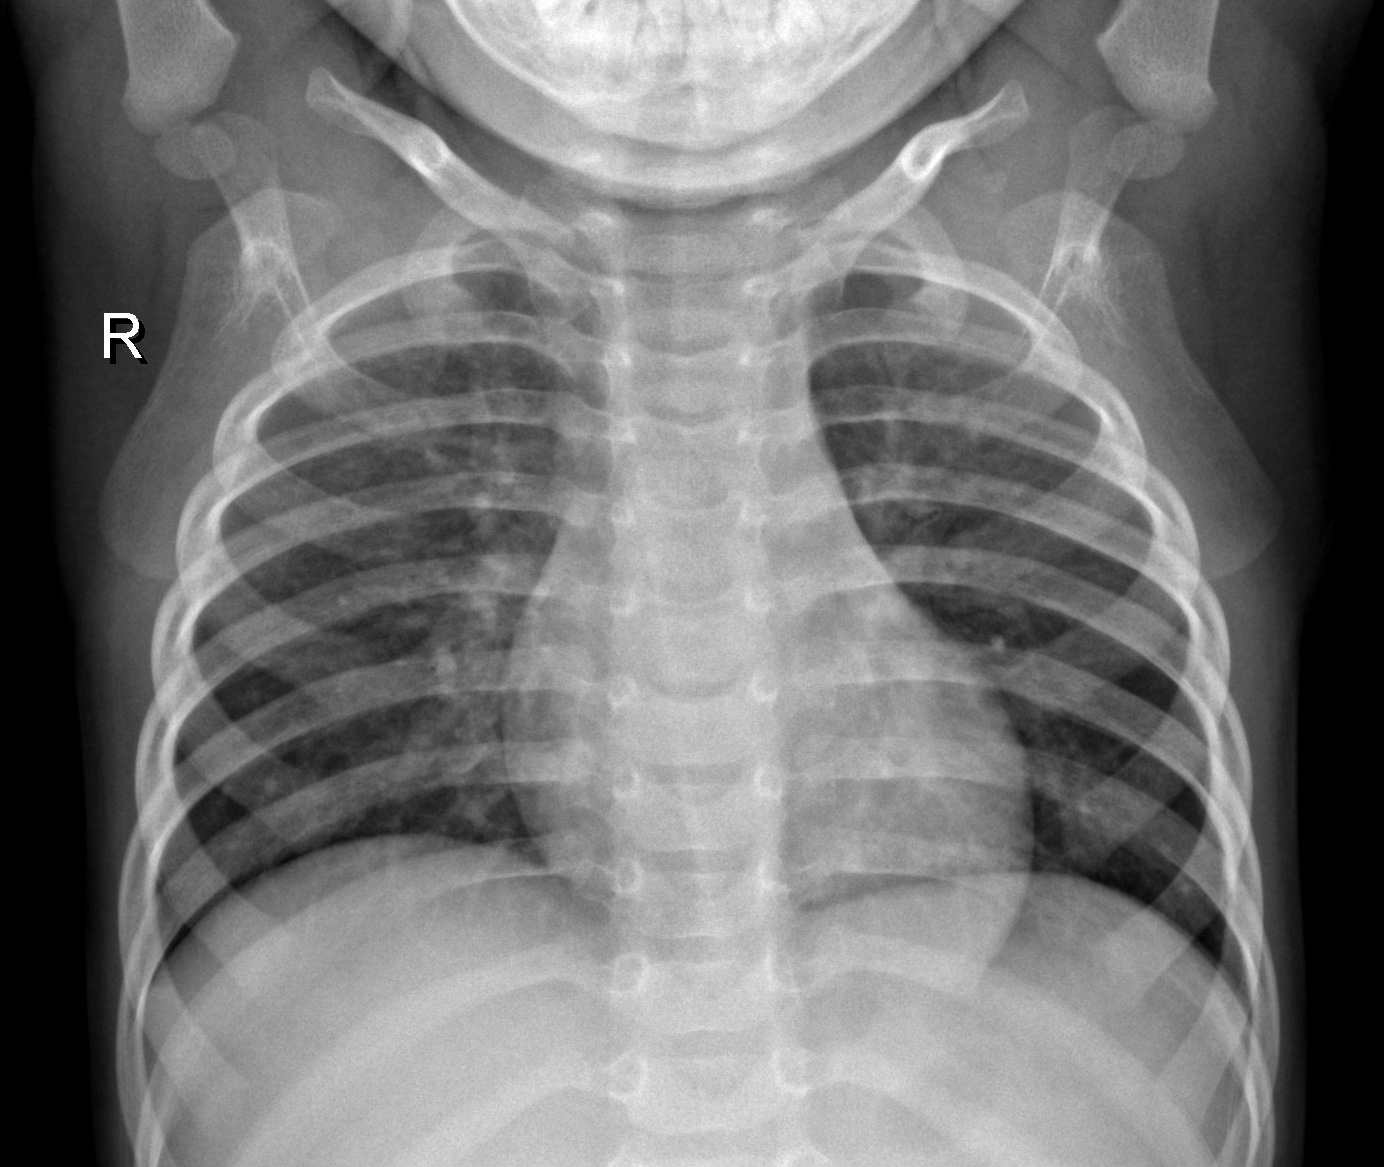

In [ ]:
PIL.Image.open(str(img_5))

In [ ]:
test_on_image(img_5)

1/1 [==============================] - 1s 1s/step


'Normal'

In [ ]:
test_on_image('/content/drive/MyDrive/ACE PROJECT/Pneumonia/person1001_bacteria_2932.jpeg')

1/1 [==============================] - 0s 79ms/step


'Pneumonia'

In [ ]:
test_on_image('/content/drive/MyDrive/abc.jpg')

1/1 [==============================] - 0s 125ms/step


'Pneumonia'

In [ ]:
test_on_image('/content/drive/MyDrive/abc.jpg')